In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
import scipy.cluster.hierarchy as shc
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering


# Explanation

One of the most interesting findings thus far is that, unlike the other two components, C2 expression resembles adult expression throughout development, even at early stages. This suggests that, even though we discovered these comoponents in an adult dataset, C2 appears to be a fetal gradient.

This gives us a potential opportunity to determine which genes might be "driving" or "organizing" the gradient. If we go by the assumption that genes with the highest overall correlation with C2 are most important to organizing the gradient, we can figure out which genes maintain a high correlation with overall C2 expression throughout development. These genes might be good candidates as driving elements of C2 organization.

A disclaimer, this is *by far* the most exploratory and least empirical analysis for this whole project. Any results here should be thought of as descriptive and suggestive.

# Load brainspan data

Please see the Brainspan notebook to learn the source of the BrainSpan data

In [2]:
# Where to save figures
fig_dir = 'figures/'

In [4]:
df = pandas.read_csv('data/expression_matrix.csv',header=None) # expression data
rmd = pandas.read_csv('data/rows_metadata.csv') # rows metadata
cmd = pandas.read_csv('data/columns_metadata.csv') # columns metadata
print (len(rmd.gene_symbol.unique()))
print (df.shape,rmd.shape)
rmd = rmd.drop_duplicates(subset=['gene_symbol'], keep='last')

labels = rmd.index.values
df = df.loc[df.index.intersection(labels)]
print (df.shape,rmd.shape)

47808
(52376, 525) (52376, 5)
(47808, 525) (47808, 5)


# Load component data

In [6]:
# This was created in NB3: PLS_ModelExploration
comps = pandas.read_csv('tables/all_comps.csv',index_col=0)
comps.head()

gene_symbol                     gene_name        C1        C2        C3  \
0        A1BG        alpha-1-B glycoprotein  0.002973  0.004339 -0.021710   
1    A1BG-AS1                           NaN -0.005849 -0.005274 -0.001815   
2         A2M         alpha-2-macroglobulin  0.006580  0.008360  0.002613   
3       A2ML1  alpha-2-macroglobulin-like 1 -0.002902 -0.003456 -0.006931   
4     A3GALT2                           NaN -0.000181  0.002546  0.004099   

   C1_genelist  C2_genelist  C3_genelist  
0          0.0          0.0          1.0  
1          0.0          0.0          0.0  
2          0.0          0.0          0.0  
3          0.0          0.0          0.0  
4          0.0          0.0          0.0

#### address duplicates

In [7]:
# dups = []
# dind = []
# catch = []
# for i,row in rmd.iterrows():
#     x = row['gene_symbol']
#     if x in catch: 
#         dups.append(x)
#         dind.append(i)
#     else:
#         catch.append(x)

In [8]:
# bad_index = rmd[rmd.gene_symbol.isin(dups)].index
# rmd.drop(bad_index,inplace=True)
# df.drop(bad_index,inplace=True)

#### harmonize genes

In [9]:
shared = list(set(rmd.gene_symbol.values) & set(comps.gene_symbol))
len(shared)

13786

In [10]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(13786, 525)

In [11]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

1          2          3          4          5          6    \
TSPAN6    36.447128  24.251253  19.330479  27.668607  19.998231  14.680673   
DPM1      34.373239  20.765661  18.734947  22.366394  19.228431  11.020365   
SCYL3      4.379337   4.227521   2.551825   3.603764   2.948976   2.405183   
C1orf112   3.957119   3.520794   2.037805   3.487035   2.177235   0.999693   
FGR        0.244174   0.266976   0.248188   0.141398   0.467688   0.296493   

                7          8          9          10   ...        515  \
TSPAN6    27.548101  16.580183  44.587799  44.943915  ...   2.320932   
DPM1      25.394607  17.671327  32.903100  38.157569  ...  23.769167   
SCYL3      3.613642   2.573935   3.483817   3.609830  ...   1.593009   
C1orf112   3.481555   1.747568   3.741580   3.560650  ...   0.583488   
FGR        0.079941   0.149822   0.204210   0.260205  ...   1.319251   

                516        517        518        519        520        521  \
TSPAN6     1.781548   2.277359   1.832737   1.555696   2.081944   3.484685   
DPM1      20.142132  20.063257  16.575379  18.783516  21.631293  28.006120   
SCYL3      1.563377   1.648571   2.231466   2.040326   2.161741   1.275352   
C1orf112   0.797376   0.607141   0.575555   0.606445   0.683625   0.495084   
FGR        2.062175   1.168233   0.681609   0.490367   0.407953   1.568014   

                522        523        524  
TSPAN6     4.816781   3.034464   3.082820  
DPM1      28.731717  16.679597  28.866042  
SCYL3      1.184766   1.735579   1.500363  
C1orf112   0.761265   0.766482   0.468859  
FGR        1.260039   1.736395   1.632879  

[5 rows x 524 columns]

#### Get gene expression for each component

In [12]:
gdf = pandas.DataFrame(cmd,copy=True)

In [13]:
n_comps = 3
comps.index = comps.gene_symbol.values
for i,col in enumerate(gxp.columns):
    for c in range(1,(n_comps+1)):
        gdf.loc[i,'C%s_exp'%c] = np.dot(gxp[col],comps.loc[gxp.index,'C%s'%c].values)

In [14]:
# in case you want to save this spreadsheet so you don't have to run the other cells
gdf.to_csv('data/GCorr_Brainspan.csv')

In [15]:
gdf = pandas.read_csv('data/GCorr_Brainspan.csv')

#### Prepare stuff for plots

In [16]:
Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [17]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs','11 yrs']
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


In [18]:
# deal with the nine months before birth before logging...
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    gdf.loc[i,'age_in_months'] = fage

In [19]:
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num)
    elif measure == 'yrs':
        fage = (int(num) * 52) + 39.105
    else:
        fage = (int(num) * 4.345) + 39.105
    gdf.loc[i,'age_in_weeks'] = fage

In [20]:
gdf.loc[:,'log_age_months'] = np.log(gdf['age_in_months']).values
gdf.loc[:,'log_age_weeks'] = np.log(gdf['age_in_weeks']).values


In [21]:
as_order = ['fetal','infant','child','adolescent','adult']
ae_order = sorted(gdf.Age_Epoch.unique())
ap_order = gdf.Age_Period.unique()

In [22]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

# Derive C2 subcluster trajectories

In [23]:
# Get the significant C2 genes
perc = 0.025 / 3
thresh = int(round(comps.shape[0] * perc))
genes = comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[-thresh:].index.tolist()
genes += comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[:thresh].index.tolist()
topgenes = pandas.DataFrame(genes)
topgenes.columns = ['C2']

In [24]:
len(genes)

260

In [25]:
cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']

Here, we are doing a similar process to what we did in the Brainspan notebook when we figured out the similarity to C2 expression for each subject. This time, we're going to do that for every gene -- that is, for each gene, we see how correlated the gene is with overall C2 expression across subjects. Given the age range of Brainspan, we are really after how the expression of each gene correlates with the overall (adult, AHBA) C2 expression over the age range. The goal is to find specific genes that are correlated with C2 expression even at the earliest timepoint.

***Note:*** This cell will take quite a long time to run, as an FYI.

In [26]:
c = 2

# Get a tiny C2 dataframe
jnk = pandas.DataFrame(gxp.T,copy=True)
for col in ['donor_id','MacroStructure2','C%s_exp'%c]:
    jnk.loc[:,col] = gdf[col].values

# load Allen Brain Atlas data
aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
               index_col=0)
aba.columns = ['ABA_mean','ABA_sem']

# create a summary dataframe and add columns
subsum = pandas.DataFrame(index=gdf.donor_id.unique())
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values

# iterage through all genes
for it,gene in enumerate(gxp.index):
    # keep track, while making sure the first few runs work before going forward
    if it == 100:
        print('first 100')
    if it % 1000 == 0:
        print('working on %s of %s'%((it+1),len(gxp)))
    # make a subject x expression dataframe for the gene
    gpdf = jnk[['donor_id',gene,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values=gene)
    gpdf.drop('GangEm',axis=1,inplace=True)
    # count how many instances (i.e. regions) have valid (not NaN) entries
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    
    # iterate through the subjects
    for i,row in gpdf.iterrows():
        # find out correlation of gene with AHBA C2 for each subject
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5: # only if 6+ valid entries
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # get non-parametric in case reviewer asks
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    # store per gene information for each subject -- r, rho and n_valid
    subsum.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

working on 1 of 13786
first 100


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 1001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 2001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 3001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 4001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 5001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 6001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 7001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 8001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 9001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 10001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 11001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 12001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

working on 13001 of 13786


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/cbi

In [27]:
# save results so you can come back to it and rerun this notebook without having to run the previous cell
subsum.to_csv('data/BioInf_rvals_C2.csv')

In [28]:
# uncomment to load saved results
#subsum = pandas.read_csv('data/BioInf_rvals_C2.csv',index_col=0)

In [29]:
# subsum = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/BioInf_rvals_C2.csv',
#                         index_col=0)

Now let's look at the distribution of r-values in our top "significantly contributing" genes, compared to the overall distribution of r-values for genes. As a reminder, the r-value is a representation of how well regional  expression of a given gene across donors correlates to the adult, AHBA C2 expression. Our hypothesis is that the distribution of r-values for "significantly contributing" C2 genes include more genes with high absolute correlations to the overall C1 expression

/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


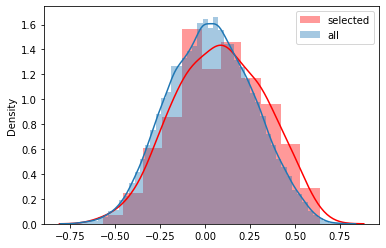

In [30]:
stat = 'r' # can change this to rho if desired
selected = subsum[['%s_%s'%(x,stat) for x in genes if x in gxp.index]].mean()
allrs = subsum[[x for x in subsum.columns if '_%s'%stat in x]].mean()
sns.distplot(selected,label='selected',color='red')
sns.distplot(allrs,label='all')
plt.legend()

There's not real purpose to this analysis, but let's see how many genes show significantly higher correlation
to AHBA C2 expression compared to the distribution of all genes. The reason this isn't an important analysis is because we're going to look at all "Top" C2 genes anyway. Why? Because this is correlation to AHBA all subject. It is possible, even likely, that a gene will be correlated with C2 only at certain timepoints, but not or even anticorrelated during others.

In [31]:

sig = []
thr = round(len(allrs)*0.025)
cil = allrs.sort_values().values[thr]
ciu = allrs.sort_values().values[-thr]
print('CI:',cil,ciu)
for x in selected.index:
    if selected[x] >= ciu or selected[x] <= cil:
        sig.append(x)
print('# significant:',len(sig))
print(sig)

CI: -0.41428571428571437 0.4979754881917801
# significant: 16
['EFR3A_r', 'GMPR_r', 'DHRS3_r', 'BCO2_r', 'VILL_r', 'OSBPL3_r', 'RBP1_r', 'KCTD4_r', 'TP53I11_r', 'ISG15_r', 'NR2F2_r', 'HIST1H2BK_r', 'HILS1_r', 'EPHA5_r', 'KCNA4_r', 'NECAB2_r']


Gene expression exhibits high autocorrelation and hierarchical structure. Rather than looking at individual genes, it may make life easier to cluster genes that show high co-expression over the lifespan together. That is the objective of the following cells.

In [32]:
c2ss = pandas.DataFrame(subsum[[x for x in subsum.columns[20:] if x.split('_')[-1] == stat and \
                                                        x.split('_')[0] in genes]],
                       copy=True)
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

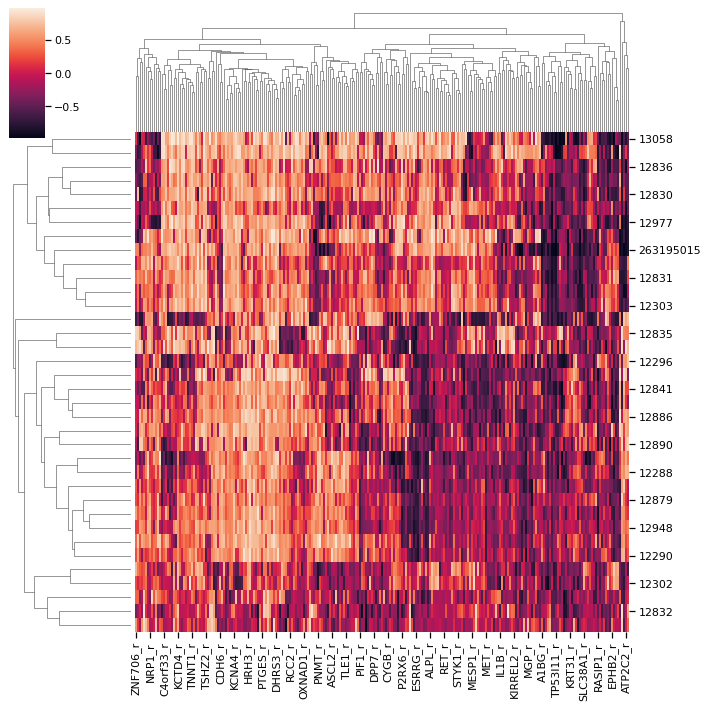

In [33]:
sns.set_context('notebook',font_scale=1)
g = sns.clustermap(c2ss)

In [34]:
# This was not at all the objective, but interesting to see how well these C2 genes alone successfully cluster
# samples based on age.
subsum.loc[g.data2d.index]['age']

13058        16 pcw
12979        19 pcw
12836        21 pcw
12833        24 pcw
12830        17 pcw
12889        16 pcw
12977        16 pcw
12365        13 pcw
263195015    12 pcw
12980        13 pcw
12831        12 pcw
12295        13 pcw
12303        12 pcw
12304        37 pcw
12835        11 yrs
13057         8 yrs
12296         3 yrs
12299        10 mos
12841         4 mos
12820         4 mos
12886         1 yrs
12834         4 yrs
12890         8 yrs
12287        23 yrs
12288        13 yrs
12880        40 yrs
12879        37 yrs
12960        30 yrs
12948        19 yrs
12837        36 yrs
12290        21 yrs
12949         9 pcw
12302         8 pcw
12984         2 yrs
12832         3 yrs
12300        18 yrs
Name: age, dtype: object

Next we will cluster the genes based on shared similarity to C2 across the lifespan. We'll use a silhoette score as a heuristic to pick the best clustering solution. This is purely a descriptive analysis so the choice of cluster doesn't matter all that much. Note also that the solution will change from run to run, so if you want an exact replication of my results, you will need to load the data I have saved at the end of the clutering section

In [35]:
csol = pandas.DataFrame()
for i,k in enumerate(range(2,100)):
    #print('working on k =',k)
    d = c2ss.T.values
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

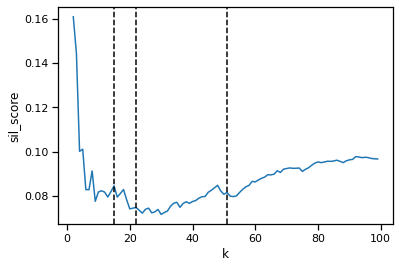

In [36]:
sns.lineplot(x='k',y='sil_score',data=csol)
peaks = [15,22,51]
for peak in peaks:
    plt.axvline(peak,ls='--',c='k')

Text(15, 0.11, 'k=15\n*')

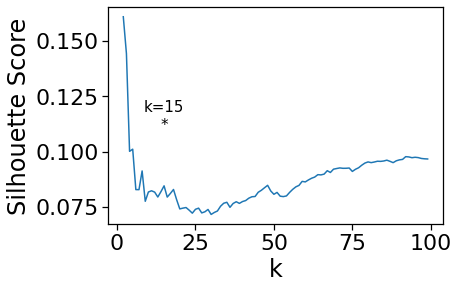

In [37]:
# make it pretty for publication
sns.set_context('notebook',font_scale=2)
sns.lineplot(x='k',y='sil_score',data=csol)
plt.ylabel('Silhouette Score')
plt.text(15,0.11,'k=15\n*',size=15,ha='center')

#plt.savefig(os.path.join(fig_dir,'C2Expl_Cluster_Solution.pdf'),bbox_inches='tight')

Probably the most obvious peak at 15, with smaller peaks at 22 and 51. We'll choose one of the peaks and try to visualize the shape of the clusters

<AxesSubplot:>

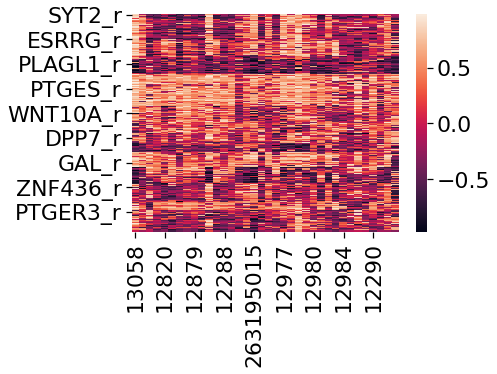

In [38]:
# cluster once more based on peak
cluster = AgglomerativeClustering(n_clusters=15, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
# sort data by cluster labels and plot
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sns.heatmap(data.sort_values('labels')[data.columns[:-1]])

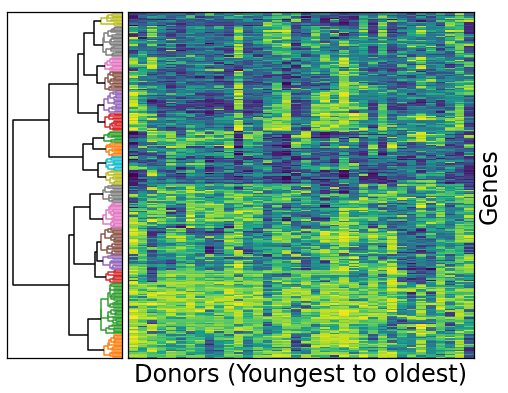

In [39]:
# Now make a version for visualization in the paper
import scipy.cluster.hierarchy as shc

# get the dendogram for the clustering solution
link = shc.linkage(c2ss.T.values, method='ward')
#dend = shc.dendrogram(link)

# get an index ordering that sorts by age
sorder = [x for x in subsum.sort_values('log_age_weeks').donor_id.values if x in c2ss.T.columns]

# define data
D = pandas.DataFrame(c2ss.T[sorder], copy=True)
D = D.values

# create dendogram
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=6,above_threshold_color='black')
ax1.set_xticks([])
ax1.set_yticks([])

# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="viridis")

# decorate
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.yaxis.set_label_position('right')
plt.xlabel('Donors (Youngest to oldest)',)
plt.ylabel('Genes')

#plt.savefig(os.path.join(fig_dir,'DendoC2.pdf'),bbox_inches='tight')
plt.show()

Here, I will save the result of my cluster solution (the one reported in the paper), so it can be fully reproduced. If you wish to reproduce this analysis, do not uncomment and run the next line, as it will overwrite the existing file

In [40]:
# data.to_csv('data/C2_Exploration_cluster_solution.csv')

# Evaluate C2 subcluster trajectories

In [41]:
## If you wish to rerun the exact analysis I did, uncomment and load this csv
# data = pandas.read_csv('data/C2_Exploration_cluster_solution.csv',index_col=0)

In [42]:
# make a cluster matrix by averaging values within-cluster
# this is a subject level plot (subject x cluster), so also add subject level variables
cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

cluster0  cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  \
13058  0.714116  0.756496 -0.351854  0.684231  0.370879 -0.238595  0.149591   
12833  0.355614  0.427066 -0.294664  0.546738  0.271510 -0.133779  0.376446   
12835 -0.111738 -0.374005  0.017288  0.470935  0.384992  0.162438 -0.329446   
12960 -0.350928 -0.002394 -0.309821  0.513481  0.408765  0.343364 -0.080972   
12820 -0.249192  0.474798 -0.365795  0.476316 -0.288183  0.219165  0.270020   

       cluster7  cluster8  cluster9  ...  Age_Period  MacroStructure  \
13058 -0.624050  0.702850 -0.571913  ...          p4         Frontal   
12833 -0.471276  0.544805 -0.335571  ...          p6          Limbic   
12835 -0.261870  0.521527  0.646473  ...         p11         Frontal   
12960 -0.271416  0.389842  0.412341  ...         p12        Temporal   
12820 -0.358130  0.182770 -0.072431  ...          p8        Temporal   

       MacroStructure2  NT_Segment  Sensorifugal  age_level  age_in_months  \
13058          Frontal        Tele   Association          4       3.678161   
12833           Limbic        Tele   Association          8       5.517241   
12835          Frontal        Tele   Association         20     132.000000   
12960         Temporal        Tele   Association         27     360.000000   
12820         Temporal        Tele   Association         13       4.000000   

      log_age_months age_in_weeks log_age_weeks  
13058       1.302413       16.000      2.772589  
12833       1.707878       24.000      3.178054  
12835       4.882802      611.105      6.415269  
12960       5.886104     1599.105      7.377199  
12820       1.386294       56.485      4.033975  

[5 rows x 35 columns]

Now, we will will observe the developmental trajectory of each gene expression cluster. This will show us how the expression of genes in each cluster changes it's similarity to the C2 gradient over (log) age. We would expect some increases and decreases over time, as well as some negative and some positive values (as there are two tails to the gradients. However, what we are counting on is that there will be at least one cluster that has a relatively high and relatively flat expression over the lifespan. We are hoping such genes may be the "gradient-organizing" genes were are looking for

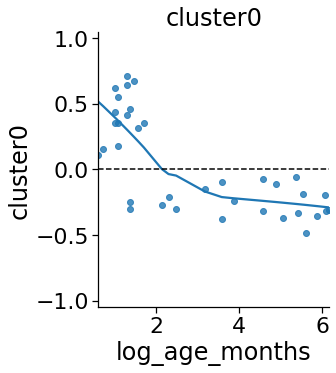

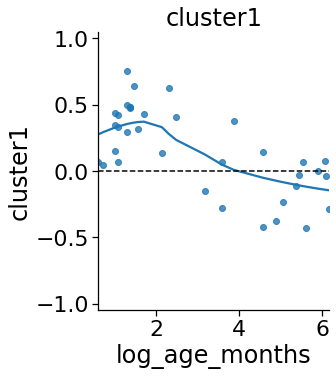

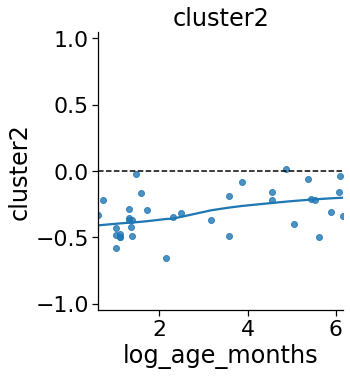

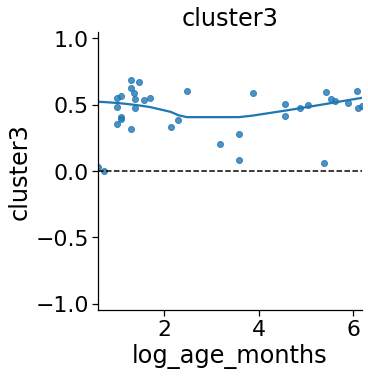

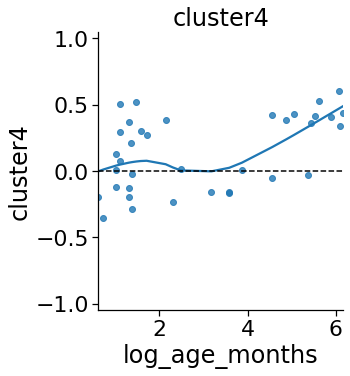

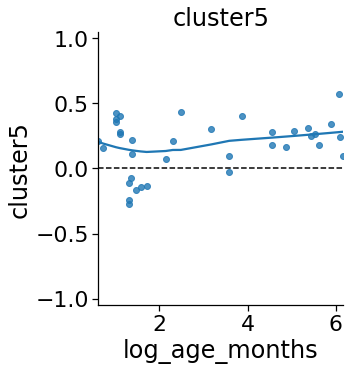

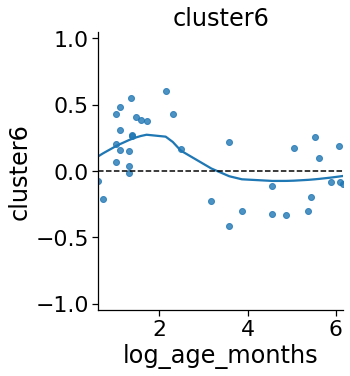

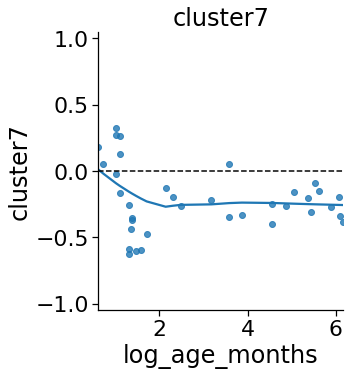

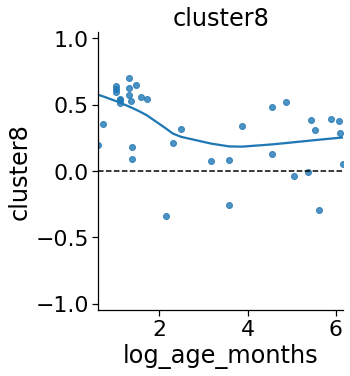

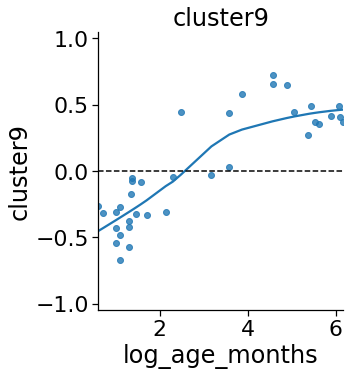

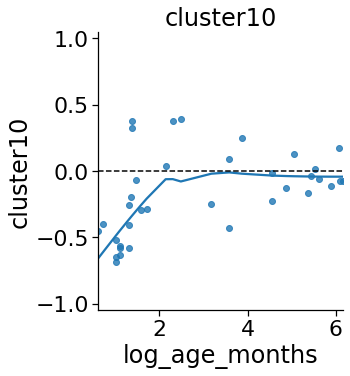

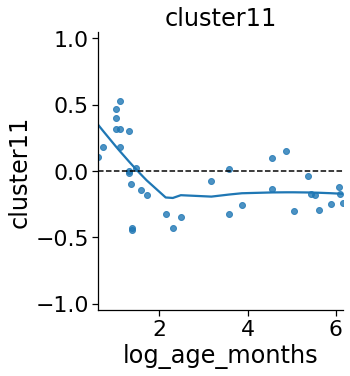

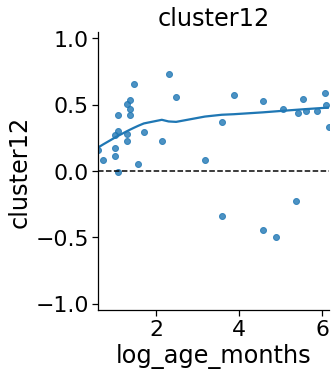

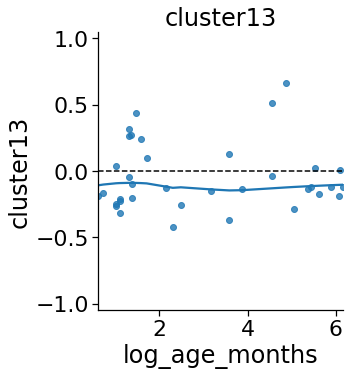

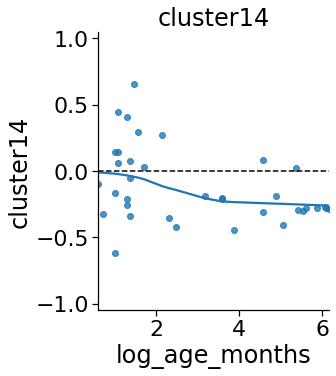

In [43]:
# for each cluster
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    # plot expression over log age
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    # decorate
    plt.ylim(-1.05,1.05)
    plt.axhline(0,ls='--',c='k')
    plt.title(cluster)
    plt.show()

It seems as though clusters 0, 1 and 2 show the characteristics we were hoping for. Next we are going to try to visualize all the clusters, and we will do so before and after applying a criteria to remove "noisy" clusters

In [44]:
# making plotting dataframe
cplots.loc[:,'ind'] = cplots.index
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_months'] = cplots.log_age_months.tolist() * len(tall.variable.unique())

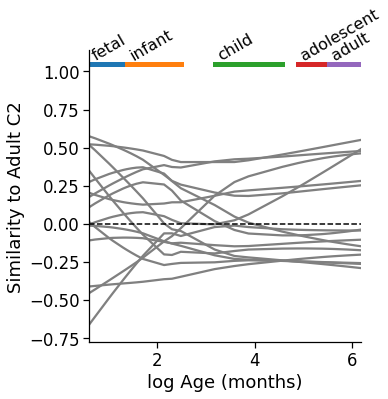

In [45]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_months',y='value',
            hue='variable',lowess=True,
             markers='',palette=['gray']*len(tall.variable.unique()),#palette=colors,
             legend=None,data=tall)
plt.ylabel('Similarity to Adult C2')
plt.xlabel('log Age (months)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'cluster_timelinesC2_k15_gray.pdf'),bbox_inches='tight')

That's a bit chaotic, and some of these clusters are likely junk. Let's narrow it down based on some sensible criteria:

#### Criteria
* Mostly genes from one tail
* Goes in the expected direction
* Reaches r > 0.5 at some point

In [46]:
# make a table indicating criteria met for each cluster
crit = pandas.DataFrame(data['labels'].unique())

# have a reference for which genes are positive and which are negative
posg = comps[(comps.gene_symbol.isin(topgenes.C2.values)) & (comps.C2>0)].index
negg = comps[(comps.gene_symbol.isin(topgenes.C2.values)) & (comps.C2<0)].index

# indicate which clusters show a flat or non-monotonic trajectory
flats = [0,1,2]

# for each cluseter
for clust in data['labels'].unique():
    cluster = 'cluster'+str(clust)
    # identifiy how many genes in the cluster on the positive vs negative tail of the gradient
    cgenes = [x.split('_')[0] for x in data[data.labels==clust].index]
    npos = len([x for x in cgenes if x in posg])
    nneg = len([x for x in cgenes if x in negg])
    
    # discover if cluster has mostly (2/3 or greater) genes from one tail
    if (npos+0.001) / (nneg+0.001) > 3:
        direction = 'pos'
    elif (npos+0.001) / (nneg+0.001) < 0.33:
        direction = 'neg'
    else:
        direction = 'ambiguous'
    crit.loc[clust,'npos'] = npos
    crit.loc[clust,'nneg'] = nneg
    crit.loc[clust,'direction'] = direction
    
    # make sure cluster goes in the expected direction given the tail the genes within belong to
    r,p = stats.spearmanr(cplots[cluster].values,cplots.log_age_months.values)
    mn = cplots[cplots.log_age_months>4][cluster].values.mean() # mean signal post childhood
    if clust in flats:
        cor = 'flat'
    elif r < 0:
        cor = 'neg'
    else:
        cor = 'pos'
    crit.loc[clust,'correlation'] = cor
    crit.loc[clust,'rho'] = r
    if mn > 0:
        mean = 'pos'
    else:
        mean = 'neg'
    crit.loc[clust,'meandir'] = mean
    crit.loc[clust,'mean'] = mn
    if mean == direction:
        crit.loc[clust,'mean_match'] = 1
    else:
        crit.loc[clust,'mean_match'] = 0
    if cor == direction:
        crit.loc[clust,'cor_match'] = 1
    else:
        crit.loc[clust,'cor_match'] = 0
    
    # See if the cluster's fitted trajectory reaches r > 0.5 at some point
    fitted = g.ax.lines[clust] # this comes from the multiline lmplot a few cells up
    max_r = np.max(abs(fitted.get_data()[1]))
    if max_r > 0.5:
        strength = True
        crit.loc[clust,'strenth_match'] = 1
    else:
        strength = False
        crit.loc[clust,'strenth_match'] = 0
    crit.loc[clust,'max_r'] = max_r
    
    # which clusters meet all criteria
    hit = False
    # flat trajectories are automatic hits
    if cor == 'flat':
        hit = True
    else:
        if direction != 'ambiguous' and \
               crit.loc[clust,'mean_match'] == 1 and strength:
            hit = True
    if hit:
        crit.loc[clust,'hit'] = 1
    else:
        crit.loc[clust,'hit'] = 0
            
            

In [47]:
crit

0  npos  nneg  direction correlation       rho meandir      mean  \
0   14  13.0  16.0  ambiguous        flat -0.715878     neg -0.258244   
1    0   4.0  15.0        neg        flat -0.563994     neg -0.137170   
2   11   9.0  11.0  ambiguous        flat  0.457585     neg -0.215684   
3    2  25.0  12.0  ambiguous         pos  0.121868     pos  0.473863   
4   13  14.0   4.0        pos         pos  0.475363     pos  0.353452   
5    7  12.0   1.0        pos         pos  0.116586     pos  0.264199   
6   12   5.0   6.0  ambiguous         neg -0.364316     neg -0.066994   
7   10   2.0   8.0        neg         neg -0.273108     neg -0.250968   
8    9   7.0  10.0  ambiguous         neg -0.529598     pos  0.216002   
9    8   7.0   1.0        pos         pos  0.798326     pos  0.469961   
10   6   4.0   6.0  ambiguous         pos  0.609211     neg -0.048999   
11   4  10.0  12.0  ambiguous         neg -0.555234     neg -0.138353   
12   5   5.0   4.0  ambiguous         pos  0.292174     pos  0.260497   
13   1   6.0   4.0  ambiguous         pos  0.141965     pos  0.000469   
14   3   3.0  11.0        neg         neg -0.347955     neg -0.232091   

    mean_match  cor_match  strenth_match     max_r  hit  
0          0.0        0.0            1.0  0.517004  1.0  
1          1.0        0.0            0.0  0.371534  1.0  
2          0.0        0.0            0.0  0.409892  1.0  
3          0.0        0.0            1.0  0.550594  0.0  
4          1.0        1.0            0.0  0.489802  0.0  
5          1.0        1.0            0.0  0.281763  0.0  
6          0.0        0.0            0.0  0.273080  0.0  
7          1.0        1.0            0.0  0.269449  0.0  
8          0.0        0.0            1.0  0.574267  0.0  
9          1.0        1.0            0.0  0.462564  0.0  
10         0.0        0.0            1.0  0.658401  0.0  
11         0.0        0.0            0.0  0.347425  0.0  
12         0.0        0.0            0.0  0.477956  0.0  
13         0.0        0.0            0.0  0.146641  0.0  
14         1.0        1.0            0.0  0.262123  0.0

* Four clusters purged due to not reaching a high enough correlation with C2 gradient anywhere during development
* Two clusters removed for not being primarily composed of genes from only one tail

Now let's plot all the trajectories again, this time excluding "noisy" clusters (based on criteria above), and coloring the lines based on whether they associate with the the positive or negative tail of the gradient over development, or whether they are flat

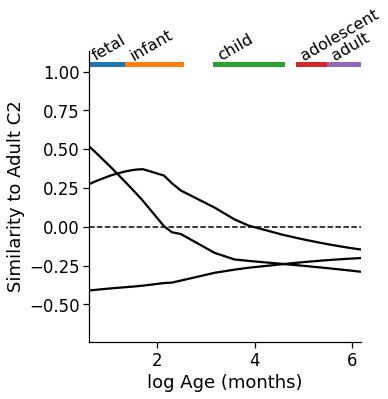

In [49]:
# derive colors
colors = []
for c,row in crit[crit.hit==1].iterrows():
    if row['correlation'] == 'flat':
        colors.append('black')
    elif row['direction'] == 'pos':
        colors.append('lightcoral')
    else:
        colors.append('lightsteelblue')

hits = ['cluster%s'%x for x in crit[crit.hit==1].index]

# plot
sns.set_context('notebook',font_scale=1.5)
g2=sns.lmplot(x='log_age_months',y='value',
            hue='variable',lowess=True,
             markers='',palette=colors,
             legend=None,data=tall[tall.variable.isin(hits)])
plt.ylabel('Similarity to Adult C2')
plt.xlabel('log Age (months)')

# decorate
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')

# plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/cluster_timelinesC2_k15_postcrit.pdf',
#            bbox_inches='tight')
#plt.savefig(os.path.join(fig_dir,'cluster_timelinesC2_k38_postcrit.pdf'),bbox_inches='tight')

There is not a whole lot more we can do with these clusters, besides describe which genes are in them. We will do one more *extremely* descriptive analysis describing the dynamics of these trajectories across development.

The idea is that we will run ANOVAs comparing the r-values across developmental stages (fetal, finant, child, adolescent, adult), and use tukey's posthoc tests to determine if C2 similarity varies significantly between stages. If so, we will use this information to descriptively categorize clusters based on when the C2 similarity "stabilizes"

<AxesSubplot:xlabel='Age_Stage'>

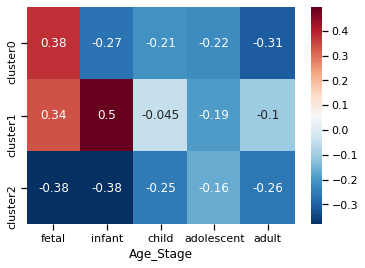

In [50]:
# a quick look at the data
sns.set_context('notebook',font_scale=1)
order = ['fetal','infant','child','adolescent','adult']
sns.heatmap(cplots.groupby('Age_Stage')[hits].mean().T[order],cmap='RdBu_r',annot=True)

In [51]:
cplots.Age_Stage.value_counts()

fetal         16
adult          6
child          6
adolescent     4
infant         4
Name: Age_Stage, dtype: int64

One problem with this approach is that there the developmental stages are highly uneven in temrs of N. So, we'll have to repeat this analysis across several balanced subsamples. As it turns out, the results don't really change at all across random subsamples, but I'll leave the machinery to check that here if you'd like to look for yourself

In [52]:
# make a function to create balanced subsamples
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [53]:
# Here we store the F and p values from the ANOVAs, as well as the group differences 
# from the Tukey posthoc tests

groupdifs = [] # to store group differences

for clust in hits :
    print('working on',clust)
    for i in range(1): # change to 10 or 100 if you wish to see how little difference varying subsamples makes
        # subsample so all categories have 4 subjects
        ss = balanced_subsample(cplots.Age_Stage)
        ssdf = pandas.DataFrame(cplots.loc[ss],copy=True)
        # get omnibus stats
        F,p = stats.f_oneway(ssdf[ssdf.Age_Stage=='fetal'][clust].values,
                  ssdf[ssdf.Age_Stage=='infant'][clust].values,
                  ssdf[ssdf.Age_Stage=='child'][clust].values,
                  ssdf[ssdf.Age_Stage=='adolescent'][clust].values,
                  ssdf[ssdf.Age_Stage=='adult'][clust].values)
        # store tukey hd output
        output = pairwise_tukeyhsd(cplots[clust],cplots.Age_Stage)
        gdiff = pandas.DataFrame(np.array(output.summary().data[1:]),
                        columns = output.summary().data[0])
        # annotate and index
        gdiff.loc[:,'F'] = F
        gdiff.loc[:,'p'] = p
        gdiff.loc[:,'cluster'] = clust
        gdiff.loc[:,'i'] = i
        groupdifs.append(gdiff)
# combine all results
results = pandas.concat(groupdifs)

working on cluster0
working on cluster1
working on cluster2


In [54]:
# tiny function to make a new column to summarize significant group differences
def func(x):
    if x == 'False':
        return 0
    else:
        return 1

results.loc[:,'reject'] = results.reject.apply(func).values

In [55]:
results

group1  group2 meandiff   p-adj    lower    upper  reject          F  \
0  adolescent   adult   -0.089     0.9  -0.4521   0.2742       0  17.333419   
1  adolescent   child   0.0098     0.9  -0.3533    0.373       0  17.333419   
2  adolescent   fetal   0.5968   0.001   0.2823   0.9113       1  17.333419   
3  adolescent  infant  -0.0484     0.9  -0.4462   0.3495       0  17.333419   
4       adult   child   0.0988     0.9   -0.226   0.4236       0  17.333419   
5       adult   fetal   0.6858   0.001   0.4164   0.9551       1  17.333419   
6       adult  infant   0.0406     0.9  -0.3225   0.4038       0  17.333419   
7       child   fetal   0.5869   0.001   0.3176   0.8563       1  17.333419   
8       child  infant  -0.0582     0.9  -0.4214    0.305       0  17.333419   
9       fetal  infant  -0.6452   0.001  -0.9597  -0.3306       1  17.333419   
0  adolescent   adult   0.0868     0.9  -0.3092   0.4827       0  12.196131   
1  adolescent   child   0.1436  0.8092  -0.2523   0.5396       0  12.196131   
2  adolescent   fetal    0.527   0.001   0.1841   0.8699       1  12.196131   
3  adolescent  infant    0.685   0.001   0.2512   1.1187       1  12.196131   
4       adult   child   0.0569     0.9  -0.2973    0.411       0  12.196131   
5       adult   fetal   0.4402  0.0012   0.1466   0.7339       1  12.196131   
6       adult  infant   0.5982  0.0011   0.2022   0.9942       1  12.196131   
7       child   fetal   0.3834  0.0056   0.0897    0.677       1  12.196131   
8       child  infant   0.5413  0.0035   0.1454   0.9373       1  12.196131   
9       fetal  infant    0.158  0.6537   -0.185   0.5009       0  12.196131   
0  adolescent   adult  -0.0965  0.8558  -0.3858   0.1929       0   1.440375   
1  adolescent   child  -0.0877     0.9   -0.377   0.2016       0   1.440375   
2  adolescent   fetal  -0.2171  0.1151  -0.4676   0.0335       0   1.440375   
3  adolescent  infant  -0.2167  0.2996  -0.5337   0.1002       0   1.440375   
4       adult   child   0.0088     0.9    -0.25   0.2675       0   1.440375   
5       adult   fetal  -0.1206  0.4922  -0.3352    0.094       0   1.440375   
6       adult  infant  -0.1202  0.7253  -0.4096   0.1691       0   1.440375   
7       child   fetal  -0.1294  0.4241  -0.3439   0.0852       0   1.440375   
8       child  infant   -0.129  0.6771  -0.4183   0.1603       0   1.440375   
9       fetal  infant   0.0004     0.9  -0.2502   0.2509       0   1.440375   

          p   cluster  i  
0  0.000017  cluster0  0  
1  0.000017  cluster0  0  
2  0.000017  cluster0  0  
3  0.000017  cluster0  0  
4  0.000017  cluster0  0  
5  0.000017  cluster0  0  
6  0.000017  cluster0  0  
7  0.000017  cluster0  0  
8  0.000017  cluster0  0  
9  0.000017  cluster0  0  
0  0.000130  cluster1  0  
1  0.000130  cluster1  0  
2  0.000130  cluster1  0  
3  0.000130  cluster1  0  
4  0.000130  cluster1  0  
5  0.000130  cluster1  0  
6  0.000130  cluster1  0  
7  0.000130  cluster1  0  
8  0.000130  cluster1  0  
9  0.000130  cluster1  0  
0  0.269141  cluster2  0  
1  0.269141  cluster2  0  
2  0.269141  cluster2  0  
3  0.269141  cluster2  0  
4  0.269141  cluster2  0  
5  0.269141  cluster2  0  
6  0.269141  cluster2  0  
7  0.269141  cluster2  0  
8  0.269141  cluster2  0  
9  0.269141  cluster2  0

In [56]:
# Create a new column representing which group comparison is being made
for i,row in results.iterrows():
    results.loc[i,'group'] = '%s_%s'%(row['group1'],row['group2'])

In [57]:
# Visualize group differences for all clusters
jnk = pandas.DataFrame(results[results.i==0])
jnk.loc[:,'ind'] = range(len(jnk))
jnk.pivot(index='group',columns='cluster',values='reject')

cluster            cluster0  cluster1  cluster2
group                                          
adolescent_adult          0         0         0
adolescent_child          0         0         0
adolescent_fetal          1         1         0
adolescent_infant         0         1         0
adult_child               0         0         0
adult_fetal               1         1         0
adult_infant              0         1         0
child_fetal               1         1         0
child_infant              0         1         0
fetal_infant              1         0         0

Record observations of change points

* C0: - (flat)
* C1: Fetal - Adult (flat)
* C2: Fetal - Adult (flat)
* C8: Fetal - Infant
* C9: Fetal - Infant
* C10: Fetal - Infant
* C11: Fetal - Adolescent
* C13: Fetal - Child
* C14: Fetal - Child


In [58]:
np.array(sns.color_palette('viridis',10))[[0,4,9]]

array([[0.283072, 0.130895, 0.449241],
       [0.143343, 0.522773, 0.556295],
       [0.762373, 0.876424, 0.137064]])

In [59]:
# Create color map around this categorization
cats = dict(zip(hits,['fetal_nl','fetal_nl','fetal_nl','infant','infant','infant',
                      'postinfant','postinfant','postinfant',]))
colos = dict(zip(['fetal_nl','infant','postinfant'],
                np.array(sns.color_palette('viridis',10))[[0,4,9]]))
pal = [colos[x] for x in cats.values()]

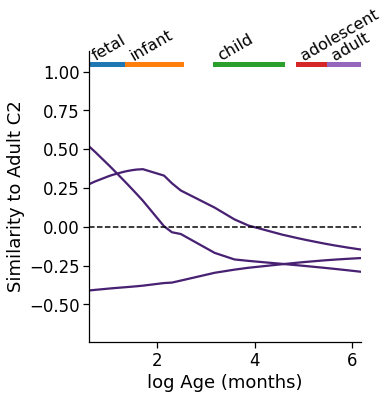

In [61]:
# plot
sns.set_context('notebook',font_scale=1.5)
g2=sns.lmplot(x='log_age_months',y='value',
            hue='variable',lowess=True,
             markers='',palette=pal,
             legend=None,data=tall[tall.variable.isin(hits)])
plt.ylabel('Similarity to Adult C2')
plt.xlabel('log Age (months)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
# plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/cluster_timelinesC2_k15_newcolors.pdf',
#            bbox_inches='tight')

#plt.savefig(os.path.join(fig_dir,'cluster_timelinesC2_k15_posttiming.pdf'),bbox_inches='tight')

# Store tables for cluster and gene-cluster relationship

In [62]:
data.loc[:,'gene_symbol'] = [x.split('_')[0] for x in data.index]

In [63]:
gene_cluster = pandas.DataFrame(data.sort_values('labels')[['gene_symbol','labels']],copy=True)
gene_cluster.index = range(len(gene_cluster))
gene_cluster.columns = ['gene','cluster']
gene_cluster

gene  cluster
0        SYT2        0
1    EPB41L4B        0
2      CITED4        0
3        JDP2        0
4       PCSK1        0
..        ...      ...
242      NID2       14
243      LCP2       14
244   ALDH1A3       14
245  TNFSF13B       14
246   CYP26B1       14

[247 rows x 2 columns]

In [64]:
gene_cluster.to_csv('tables/C2_GeneCluster.csv')

In [65]:
for i,row in crit.iterrows():
    c = 'cluster%s'%i
    if c in cats.keys():
        crit.loc[i,'category'] = cats[c]

In [66]:
crit.columns = ['cluster','N pos. genes','N neg. genes','dom. direction','correlation',
                'r-value','obs. mean direction','mean C2 similarity',
               'mean match','cor match','strength match','max C2 similarity','good?','category']
crit.drop(['correlation','r-value','cor match'],axis=1,inplace=True)
crit

cluster  N pos. genes  N neg. genes dom. direction obs. mean direction  \
0        14          13.0          16.0      ambiguous                 neg   
1         0           4.0          15.0            neg                 neg   
2        11           9.0          11.0      ambiguous                 neg   
3         2          25.0          12.0      ambiguous                 pos   
4        13          14.0           4.0            pos                 pos   
5         7          12.0           1.0            pos                 pos   
6        12           5.0           6.0      ambiguous                 neg   
7        10           2.0           8.0            neg                 neg   
8         9           7.0          10.0      ambiguous                 pos   
9         8           7.0           1.0            pos                 pos   
10        6           4.0           6.0      ambiguous                 neg   
11        4          10.0          12.0      ambiguous                 neg   
12        5           5.0           4.0      ambiguous                 pos   
13        1           6.0           4.0      ambiguous                 pos   
14        3           3.0          11.0            neg                 neg   

    mean C2 similarity  mean match  strength match  max C2 similarity  good?  \
0            -0.258244         0.0             1.0           0.517004    1.0   
1            -0.137170         1.0             0.0           0.371534    1.0   
2            -0.215684         0.0             0.0           0.409892    1.0   
3             0.473863         0.0             1.0           0.550594    0.0   
4             0.353452         1.0             0.0           0.489802    0.0   
5             0.264199         1.0             0.0           0.281763    0.0   
6            -0.066994         0.0             0.0           0.273080    0.0   
7            -0.250968         1.0             0.0           0.269449    0.0   
8             0.216002         0.0             1.0           0.574267    0.0   
9             0.469961         1.0             0.0           0.462564    0.0   
10           -0.048999         0.0             1.0           0.658401    0.0   
11           -0.138353         0.0             0.0           0.347425    0.0   
12            0.260497         0.0             0.0           0.477956    0.0   
13            0.000469         0.0             0.0           0.146641    0.0   
14           -0.232091         1.0             0.0           0.262123    0.0   

    category  
0   fetal_nl  
1   fetal_nl  
2   fetal_nl  
3        NaN  
4        NaN  
5        NaN  
6        NaN  
7        NaN  
8        NaN  
9        NaN  
10       NaN  
11       NaN  
12       NaN  
13       NaN  
14       NaN

In [67]:
gene_cluster.to_csv('tables/C2_GeneClusterAttributes.csv')

#### Leaving this here in case I want to come back later and try GO analysis

In [68]:
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
bigdf = pandas.read_csv('/Users/jacobv/Downloads/bigdf.csv',index_col=0)
probes = probes[probes.gene_symbol.isin(bigdf.columns)]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jacobv/abagen-data/microarray/normalized_microarray_donor10021/Probes.csv'

In [ ]:
jnkF = ['HS3ST1', 'ATP4A', 'PLEKHM2', 'KCNC1', 'KCNC3', 'SCRT1', 'THEMIS',
       'PELI3', 'EIF4E1B', 'CAMK1D', 'ASB13', 'KCNG1', 'ADAMTSL1',
       'FABP5P3', 'ATP2B3', 'NDRG3', 'NFIC', 'PPFIA4', 'BEND6', 'ZBTB8A',
       'GLIS1', 'RPS6KA3', 'SECISBP2', 'SDK2', 'SEMA3C', 'ANKRD50',
       'ROBO2', 'HRH3', 'SLC4A3', 'TSPAN2', 'AMIGO2', 'SKAP1', 'SLC26A11',
       'SGSH', 'GPRIN2']
jnkI = ['IDS', 'PDIA5', 'LXN', 'SMPX', 'PPM1H', 'CTNNAL1', 'C5orf24',
       'ARL9', 'RAD54B', 'LYRM4', 'MYBPHL', 'BID', 'ST3GAL6', 'TSPAN1',
       'MICAL2', 'TBR1', 'SEMA7A', 'FAM13A', 'CPLX2', 'CNKSR2', 'ATP2B2',
       'CABP1', 'COX7A1', 'KLF13', 'UBE2QL1', 'WISP2', 'FABP5', 'GPX3',
       'ADCYAP1R1', 'PITPNC1', 'CYB5R1', 'MT1F', 'RYR3', 'ITPKC', 'FRAT1',
       'FRAT2', 'CUX1', 'DSP', 'ARSG', 'LPP', 'SLC38A11', 'FES', 'RCSD1',
       'PCSK5', 'NTSR1', 'SLC35F2', 'PAX8', 'SYT6', 'IL17RD', 'ADAMTS9',
       'NAV2', 'TSKU', 'AEBP1', 'SLC27A6', 'PRRX1', 'TGFBI', 'COL21A1',
       'APLNR', 'GXYLT2', 'NUPR1', 'THBD', 'TCEA3', 'CENPJ', 'CCDC88B',
       'SYCP2', 'COL27A1']
jnkC = ['ARHGAP4', 'GRP', 'WTIP', 'ST20', 'PRR5', 'SCN1B', 'TFAM', 'DCPS',
       'NNMT', 'KCNAB3', 'RTKN2', 'PRC1', 'ENOX1', 'SOX11', 'CACNA1H',
       'DDAH2'] + ['IDS', 'PDIA5', 'LXN', 'SMPX', 'PPM1H', 'CTNNAL1', 'C5orf24',
       'ARL9', 'RAD54B', 'LYRM4', 'MYBPHL']
for x in jnkC: print(x)
# string = ''
# for x in jnk: 
#     string+=(x+' ')
# print(string)
# j2 = probes[probes.gene_symbol.isin(jnkI)].groupby('gene_symbol'
#                                             ).entrez_id.first().values.astype(int)
# string = ''
#for x in j2: print(x)
# for x in j2: 
#     string+=(str(x)+' ')
# print(string)

ARHGAP4
GRP
WTIP
ST20
PRR5
SCN1B
TFAM
DCPS
NNMT
KCNAB3
RTKN2
PRC1
ENOX1
SOX11
CACNA1H
DDAH2
IDS
PDIA5
LXN
SMPX
PPM1H
CTNNAL1
C5orf24
ARL9
RAD54B
LYRM4
MYBPHL


In [ ]:
# j2 = probes.groupby('gene_symbol'
#                    ).entrez_id.first().values.astype(int)
# for x in j2: print(x)